In [1]:
%matplotlib inline

import math

import numpy as np
import matplotlib.pyplot as plt

import sys; sys.path.insert(0, '..')
import tonyear

from carbonplan import styles
styles.mpl.set_theme(style='carbonplan_light', font_scale=1.25)

# Carbon Impulse Response Function (i.e. the baseline curve)


An Impulse Reponse Function (IRF) represents the time-dependent fraction of an emission pulse
remaining in the atmosphere at time t. It is usually approximated by a sum of exponentials:

$ IRF_x(t) = a_{x,0} + \sum_{i=1}^{3} a_{x,i} * e^{-t / tau_i} $

The $a$ and $tau$ parameters for CO2 can be taken from literature:

- Joos, F., Roth, R., Fuglestvedt, J. S., Peters, G. P., Enting, I. G., von Bloh, W., Brovkin, V.,
  Burke, E. J., Eby, M., Edwards, N. R., Friedrich, T., Frölicher, T. L., Halloran, P. R., Holden,
  P. B., Jones, C., Kleinen, T., Mackenzie, F. T., Matsumoto, K., Meinshausen, M., Plattner, G.-K.,
  Reisinger, A., Segschneider, J., Shaffer, G., Steinacher, M., Strassmann, K., Tanaka, K.,
  Timmermann, A., and Weaver, A. J.: Carbon dioxide and climate impulse response functions for the
  computation of greenhouse gas metrics: a multi-model analysis, Atmos. Chem. Phys., 13, 2793–2825,
  https://doi.org/10.5194/acp-13-2793-2013, 2013.

* Forster, P., V. Ramaswamy, P. Artaxo, T. Berntsen, R. Betts, D.W. Fahey, J. Haywood, J. Lean, D.C.
  Lowe, G. Myhre, J. Nganga, R. Prinn, G. Raga, M. Schulz and R. Van Dorland, 2007: Changes in
  Atmospheric Constituents and in Radiative Forcing. In: Climate Change 2007: The Physical Science
  Basis. Contribution of Working Group I to the Fourth Assessment Report of the Intergovernmental
  Panel on Climate Change [Solomon, S., D. Qin, M. Manning, Z. Chen, M. Marquis, K.B. Averyt,
  M.Tignor and H.L. Miller (eds.)]:
  https://www.ipcc.ch/site/assets/uploads/2018/02/ar4-wg1-chapter2-1.pdf (pg. 213)

- IPCC: Special Report on Land Use, Land‐Use Change, and Forestry, Section 2.3.6.3, 2000,
  https://archive.ipcc.ch/ipccreports/sres/land_use/index.php?idp=74 and footnote
  https://archive.ipcc.ch/ipccreports/sres/land_use/fn3.htm#4

See our 'overview' in the documentation for the tonyear module for a more in-depth discussion of IRF
curves.


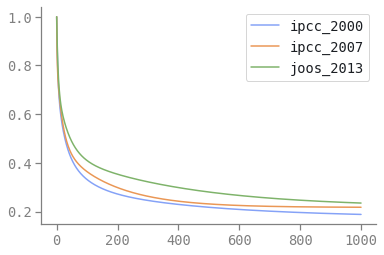

In [2]:
ipcc_2000 = tonyear.get_baseline_curve("ipcc_2000")
ipcc_2007 = tonyear.get_baseline_curve("ipcc_2007")
joos_2013 = tonyear.get_baseline_curve("joos_2013")
plt.plot(ipcc_2000, label="ipcc_2000")
plt.plot(ipcc_2007, label="ipcc_2007")
plt.plot(joos_2013, label="joos_2013")
plt.legend()

# Ton-year accounting methods


The ton-year module calculates the benefit of a delayed emission according one of two ton-year
accounting methods: Moura Costa or Lashof. Examples of both of these methods are shown below.

### Parameters

- method : (str) The ton-year accounting method (Moura Costa: 'mc', or Lashof: 'lashof')
- baseline : (np.ndarray) Array modeling the residence of an emission in the atmosphere over time,
  i.e. a decay curve / impulse response function
- time_horizon : (int) Specifies the period over which the impact of an emission is considered
  (years)
- delay : (int) Specifies the emission delay for which a ton-year benefit will be calculated (years)
- discount_rate : (float) Specifies the discount rate to apply time preference to both costs and
  benefits over the time horizon

See our 'overview' in the documentation for the tonyear module for a more in-depth discussion of
these parameters.

### Returns

- method_dict : (dict) Dictionary with the following keys: parameters: key parameters used for the
  calculation baseline: array modeling baseline emission curve (discounted if applicable) scenario:
  array modeling the scenario curve (discounted if applicable) baseline_atm_cost: the cost of of a
  baseline emission (ton-years) benefit: the benefit of delaying an emission, calculated according
  to specified accounting method (ton-years) num_for_equivalence: the ratio between the baseline
  cost and the benefit


## Moura-Costa


Moura Costa calculates the benefit of carbon storage in the most straightforward way possible: count
up the number of tons stored and multiply by the storage duration. In other words, Moura Costa looks
at the carbon-storage, but does not does not directly quantify atmospheric outcomes nor consider the
potential impact of re-emission after the temporary storage period.

The Moura Costa ton year accounting method is described in Moura Costa and Wilson, 2000:
https://oxfordclimatepolicy.org/sites/default/files/10.1023%252FA_1009697625521.pdf

Method is also referenced in the IPCC Special Report (2000):
https://archive.ipcc.ch/ipccreports/sres/land_use/index.php?idp=74

We show an example of the tonyear module's Moura Costa ton-year calculation below, using the
parameters from the IPCC Special Report.


In [3]:
time_horizon = 100
delay = 46
baseline = ipcc_2000
discount_rate = 0.0

mm = tonyear.calculate_tonyears("mc", baseline, time_horizon, delay, discount_rate)

With the output dictionary returned by the calculate_tonyears method, we can print a benefit report
to quickly summarize the outputs of the calculation:recreate the visualizations used to anchor
explanations of the Moura Costa method in literature.


In [4]:
tonyear.print_benefit_report(mm)


Discount rate: 0.0%
Delay: 46 year(s)
Baseline atmospheric cost: 45.76 ton-years
Benefit from 1tCO2 with delay: 46.0 ton-years
Number needed: 1.0



We can also use the output dictionary to recreate the visualizations used to anchor explanations of
the Moura Costa method in literature.


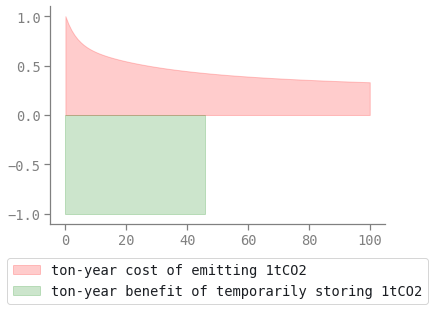

In [5]:
t = np.arange(mm["parameters"]["time_horizon"] + 1)
plot = plt.fill_between(
    t,
    mm["baseline"],
    color="red",
    alpha=0.2,
    label="ton-year cost of emitting 1tCO2",
)
plot = plt.fill_between(
    t[: len(mm["scenario"])],
    mm["scenario"],
    where=(np.array(mm["scenario"]) < 0),
    color="green",
    alpha=0.2,
    label="ton-year benefit of temporarily storing 1tCO2",
)
plt.legend(loc="lower center", bbox_to_anchor=(0.5, -0.4))

According to the Moura Costa method, the benefit of the temporary storage is simply the ton-years
represented by the green rectangle in the figure above. The green area is compared to the red area
to determine the equivalency ratio, or in other words, the number of tCO2 stored for the specified
delay to produce an "equivalent" climate outcome as the emission. See our
[ton-year explainer](https://carbonplan.org/research/ton-year-explainer) for further discussion
about the shortcomings of this approach. In short, it is our opinion that the claims made by the
Moura Costa method are not physically credible and that the method should not be used to establish
climate-equivalency claims or issue carbon offsets. Since the method is in use and poised for
expansion, we include it in the module.


## Lashof


Lashof looks only at the atmospheric outcomes and assumes that the temporarily stored carbon is
fully re-emitted at the end of the storage period. Lashof’s benefit calculation asks how many
ton-years of atmospheric impact are avoided within the specified time horizon.

The method is described in Fearnside, Lashof & Moura-Costa, 2000:
https://link.springer.com/article/10.1023%2FA%3A1009625122628

Method is also referenced IPCC Special report, 2000:
https://archive.ipcc.ch/ipccreports/sres/land_use/index.php?idp=74

We show an example of the tonyear module's Moura Costa ton-year calculation below, using the
parameters from the IPCC Special Report.


In [6]:
time_horizon = 100
delay = 46
baseline = ipcc_2000
discount_rate = 0.0

l = tonyear.calculate_tonyears("lashof", baseline, time_horizon, delay, discount_rate)

In [7]:
tonyear.print_benefit_report(l)


Discount rate: 0.0%
Delay: 46 year(s)
Baseline atmospheric cost: 45.76 ton-years
Benefit from 1tCO2 with delay: 16.64 ton-years
Number needed: 2.8



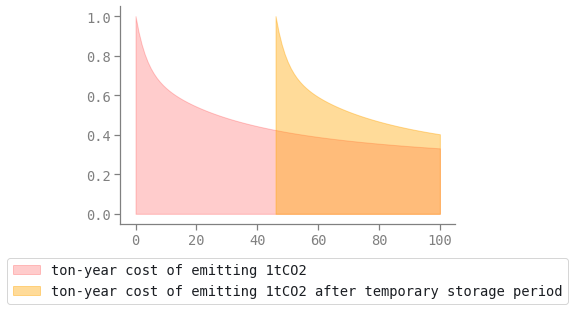

In [8]:
t = np.arange(l["parameters"]["time_horizon"] + 1)
plot = plt.fill_between(
    t,
    l["baseline"],
    color="red",
    alpha=0.2,
    label="ton-year cost of emitting 1tCO2",
)
plot = plt.fill_between(
    t,
    l["scenario"],
    where=(t >= l["parameters"]["delay"]),
    color="orange",
    alpha=0.4,
    label="ton-year cost of emitting 1tCO2 after temporary storage period",
)
plt.legend(loc="lower center", bbox_to_anchor=(0.5, -0.4))

Lashof calculated the benefit of temporary storage as the difference between the red area (the
ton-year cost of the emission) and the orange area (the ton-year cost of re-emitting 1tCO2 after a
temporary storage period). This benefit calculation is thus based on the conservative assumption
that carbon is fully re-emitted after the temporary storage period.

This benefit calculation is often visualized as shown below. In this visualization of Lashof, the
the post-storage emission is simply the baseline emission shifted over to account for the temporary
storage period. The post-storage emission thus extends past the time-horizon by {{delay}} years. The
area of sticking out past the time horizon is equivalent to the ton-years of atmospheric impact that
are avoided within the specified time horizon.

These two methods for visualizing and calculating the Lashof benefit are equivalent in the absence
of a discount rate.


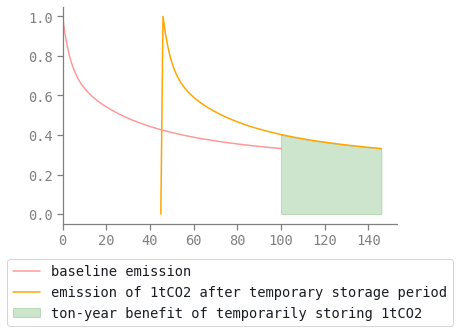

In [9]:
t = np.arange(l["parameters"]["time_horizon"] + l["parameters"]["delay"] + 1)
plot = plt.plot(l["baseline"], color="red", alpha=0.4, label="baseline emission")

final_storage_year = l["parameters"]["delay"] - 1
shifted_baseline = np.concatenate((np.zeros(l["parameters"]["delay"]), l["baseline"]))

plot = plt.plot(
    t[final_storage_year:],
    shifted_baseline[final_storage_year:],
    color="orange",
    label="emission of 1tCO2 after temporary storage period",
)

plot = plt.fill_between(
    t[l["parameters"]["time_horizon"] :],
    shifted_baseline[100:],
    color="green",
    alpha=0.2,
    label="ton-year benefit of temporarily storing 1tCO2",
)

plt.xlim(0)
plt.legend(loc="lower center", bbox_to_anchor=(0.5, -0.5))